# Training an MLP on MNIST

In [ ]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn import model_selection
from PIL import Image

## Dataset manipulation

1. Download the MNIST dataset contained in the files 'handwritten_digits_images.csv' and 'handwritten_digits_labels.csv'
2. Write code that loads this dataset by storing images (represented as np.arrays) and labels in variables X and y respectively, then splits X and y into train/validation/test sets and finally saves the images in .jpeg or .png format following a specific hierarchy.

In [ ]:
#Get Data
#Get Data
X = pd.read_csv('handwritten_digits_images.csv', header=None).to_numpy()
y = pd.read_csv('handwritten_digits_labels.csv', header=None).to_numpy()

#Train-test-split
seed = 42
X_train, X_val_test, y_train, y_val_test = model_selection.train_test_split(X,y, test_size=0.2, shuffle=True, random_state=seed)
seed = 123
X_val, X_test, y_val, y_test = model_selection.train_test_split(X_val_test,y_val_test, test_size=0.5, shuffle=True, random_state=seed)

In [ ]:
#Save as images
if not os.path.exists('MNIST'):
    os.mkdir('./MNIST')

#save train dataset
if not os.path.exists('MNIST/train'):
    os.mkdir('./MNIST/train')
for index, obj in enumerate(X_train):
    obj_shape = np.reshape(obj, (28,28))
    obj_shape = obj_shape.astype(np.uint8)
    img = Image.fromarray(obj_shape, mode='L')
    label_path = 'MNIST/train/' + str(y_train[index][0])
    if not os.path.exists(label_path):
        os.mkdir(label_path)
    img.save(label_path + '/img' + str(index) + '.png', format='PNG')

#save val dataset
if not os.path.exists('MNIST/val'):
    os.mkdir('./MNIST/val')
for index, obj in enumerate(X_val):
    obj_shape = np.reshape(obj, (28,28))
    obj_shape = obj_shape.astype(np.uint8)
    img = Image.fromarray(obj_shape, mode='L')
    label_path = 'MNIST/val/' + str(y_val[index][0])
    if not os.path.exists(label_path):
        os.mkdir(label_path)
    img.save(label_path + '/img' + str(index) + '.png', format='PNG')

#save test dataset
if not os.path.exists('MNIST/test'):
    os.mkdir('./MNIST/test')
for index, obj in enumerate(X_test):
    obj_shape = np.reshape(obj, (28,28))
    obj_shape = obj_shape.astype(np.uint8)
    img = Image.fromarray(obj_shape, mode='L')
    label_path = 'MNIST/test/' + str(y_test[index][0])
    if not os.path.exists(label_path):
        os.mkdir(label_path)
    img.save(label_path + '/img' + str(index) + '.png', format='PNG')

In [ ]:
#define parameters for quick changes
batch_size = 10
learning_rate = .8
epochs = 20
criterion = nn.CrossEntropyLoss()

#data preprocessor
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Pad(2, fill=0),
    transforms.ToTensor(),
])

#create the datasets
train = torchvision.datasets.ImageFolder(root='./MNIST/train', transform=transform)
test = torchvision.datasets.ImageFolder(root='./MNIST/test', transform=transform)
val = torchvision.datasets.ImageFolder(root='./MNIST/val', transform=transform)

#instantiate generators for the datasets
trainloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test, batch_size=1)
valloader = torch.utils.data.DataLoader(val, batch_size=1)

6. In which context do we need data generators? How do data generators typically work?

=> Data generators enable to automatically load the data in the form of batchesthat can be directly used for training/validation/testing. The format of the batches can vary and be manipulated in different ways. Usually data generators create a minibatch of the data and put them in a tensor. How the data is sampled into the batches can then be further defined with a sampler.

## Write simple MLP and train it

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

#define MLP
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(1 * 32 * 32, 512),
    nn.Sigmoid(),
    nn.Linear(512,256),
    nn.Sigmoid(),
    nn.Linear(256,64),
    nn.Sigmoid(),
    nn.Linear(64,10),
    nn.Softmax(dim=1)
)

train_acc = np.array([])
train_loss = np.array([])
val_acc = np.array([])
val_loss = np.array([])

#training loop
model = model.double()
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for epoch in range(epochs):  # loop over the dataset multiple times
  running_loss = .0
  running_acc = .0
  correct = 0
  total = 0

  for i, data in enumerate(trainloader, 0):
    model.train()
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data[0].to(device), data[1].to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = model(inputs.double())
    loss = criterion(outputs.double(), labels)
    loss.backward()
    optimizer.step()

    # calculate running loss
    running_loss += loss.item() * labels.size(0)
    # calculate accuracy
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    # print every 500 mini-batches
    if i % 500 == 499:
      print('[%d, %5d] loss: %.3f' %
        (epoch + 1, i + 1, running_loss / total))
      print('\t   accuracy: %.2f %%' %((correct/total) * 100))
  train_acc = np.append(train_acc, correct/total)
  train_loss = np.append(train_loss, running_loss/total)

  #get validarion accuracy
  correct = 0
  total = 0
  model.eval()
  v_loss = .0
  with torch.no_grad():
    for data in valloader:
      feature, labels = data[0].to(device), data[1].to(device)
      val_output = model(feature.double())
      v_loss += criterion(val_output.double(), labels).item() * labels.size(0)
      _, predicted = torch.max(val_output.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  print('Evaluation on validation data: ')
  print('Accuracy: %.2f %%' % (100 * correct / total))
  print('Loss: %.3f' %(v_loss / total))
  val_acc = np.append(val_acc, correct/total)
  val_loss = np.append(val_loss, v_loss/total)


print('Finished Training')
# test the network on the UNBIASED test data
correct = 0
total = 0
model.eval()
test_loss = .0
with torch.no_grad():
  for data in testloader:
    feature, labels = data[0].to(device), data[1].to(device)
    test_output = model(feature.double())
    test_loss += criterion(test_output.double(), labels).item() * labels.size(0)
    _, predicted = torch.max(test_output.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
print('Evalutation on test data: ')
print('Accuracy: %.2f %%' % (100 * correct / total))
print('Loss: %.3f' %(test_loss / total))

cuda:0
[1,   500] loss: 2.305
	   accuracy: 9.62 %
[1,  1000] loss: 2.303
	   accuracy: 10.39 %
[1,  1500] loss: 2.303
	   accuracy: 10.69 %
[1,  2000] loss: 2.302
	   accuracy: 10.96 %
[1,  2500] loss: 2.302
	   accuracy: 10.98 %
[1,  3000] loss: 2.297
	   accuracy: 11.41 %
[1,  3500] loss: 2.284
	   accuracy: 12.95 %
[1,  4000] loss: 2.265
	   accuracy: 15.19 %
[1,  4500] loss: 2.248
	   accuracy: 17.29 %
[1,  5000] loss: 2.231
	   accuracy: 19.27 %
[1,  5500] loss: 2.215
	   accuracy: 21.17 %
Evaluation on validation data: 
Accuracy: 43.07 %
Loss: 2.031
[2,   500] loss: 2.013
	   accuracy: 44.08 %
[2,  1000] loss: 1.997
	   accuracy: 45.77 %
[2,  1500] loss: 1.963
	   accuracy: 49.50 %
[2,  2000] loss: 1.935
	   accuracy: 52.58 %
[2,  2500] loss: 1.910
	   accuracy: 55.21 %
[2,  3000] loss: 1.890
	   accuracy: 57.22 %
[2,  3500] loss: 1.872
	   accuracy: 59.07 %
[2,  4000] loss: 1.851
	   accuracy: 61.21 %
[2,  4500] loss: 1.833
	   accuracy: 63.02 %
[2,  5000] loss: 1.818
	   accur

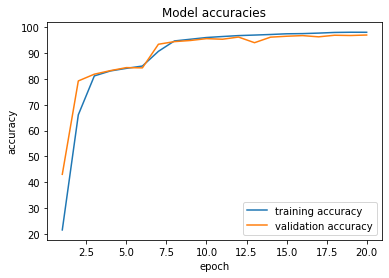

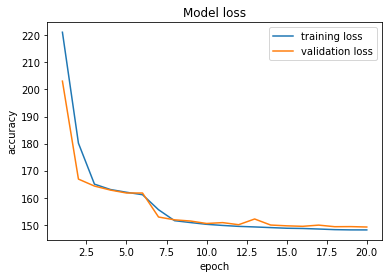

In [ ]:
#plot accuracies
ep_range = np.arange(start=1, stop=epochs+1)
plt.plot(ep_range, train_acc * 100, label='training accuracy')
plt.plot(ep_range, val_acc * 100, label='validation accuracy')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Model accuracies')
plt.show()

#plot loss
plt.plot(ep_range, train_loss * 100, label='training loss')
plt.plot(ep_range, val_loss * 100, label='validation loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Model loss')
plt.show()

## Model description

In the end the chosen model is a Neural Network with 4 hidden layers, each reducing the size of the input. It has 4 output neurons, one for each class of the dataset. This amount of layers makes the training time reasonable while yielding very good accuracies in a short amount of epochs.

Looking at the plots of the training and validation loss, I would choose to train the final model for 8 epochs, as this amount has the best validation loss without overfitting on the training data. 
I trained for 20 epochs to log all the loss and accuracies and afterwards based on the plot choose the best configuration.

The batch-size is set to 10 to speed up the process a little bit (vs having a batch-size of 1), but this parameter can still be improved for better performance, as 10 was just my first choice, which seemed to work out well.

The learning rate is set at .8 to get good results relativeley quickly. I played around with the learning rate between .1 and 1 and .8 seems to be a good choice.

All the hyperparameter choices are made by hand after running the model in different configurations and therefore not really optimized. It was enough to get the desired accuracy on the test set.